# part0: imports

In [2]:
import os, sys, pathlib
from pprint import pprint
import gc
import pickle
from importlib import reload
import logging, warnings
logging.basicConfig(level=logging.ERROR)



import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
import scipy.linalg as linalg

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib
from matplotlib.ticker import MaxNLocator


from tools import utilityTools as utility
from tools import dataTools as dt
import pyaldata as pyal

%matplotlib inline
reload(dt)

if "__file__" not in dir():
    # Global params
    root = pathlib.Path("/data")

    BIN_SIZE = .03  # sec
    WINDOW_prep = (-.4, .05)  # sec
    WINDOW_exec = (-.05, .40)  # sec
    n_components = 10  # min between M1 and PMd
    areas = ('M1', 'PMd')

    prep_epoch = pyal.generate_epoch_fun(start_point_name='idx_movement_on',
                                         rel_start=int(WINDOW_prep[0]/BIN_SIZE),
                                         rel_end=int(WINDOW_prep[1]/BIN_SIZE)
                                        )
    exec_epoch = pyal.generate_epoch_fun(start_point_name='idx_movement_on', 
                                         rel_start=int(WINDOW_exec[0]/BIN_SIZE),
                                         rel_end=int(WINDOW_exec[1]/BIN_SIZE)
                                        )
    fixation_epoch = pyal.generate_epoch_fun(start_point_name='idx_target_on', 
                                             rel_start=int(WINDOW_prep[0]/BIN_SIZE),
                                             rel_end=int(WINDOW_prep[1]/BIN_SIZE)
                                            )
    %run dataset_selection.ipynb

the variable `GoodDataList` contains the session names


In [3]:
def get_target_id(trial):
    return int(np.round((trial.target_direction + np.pi) / (0.25*np.pi))) - 1

In [4]:
def prep_general (df):
    "preprocessing general!"
    time_signals = [signal for signal in pyal.get_time_varying_fields(df) if 'spikes' in signal]
    df["target_id"] = df.apply(get_target_id, axis=1)  # add a field `target_id` with int values

    for signal in time_signals:
        df_ = pyal.remove_low_firing_neurons(df, signal, 1)
    
    df_= pyal.select_trials(df, df.result== 'R')
    df_= pyal.select_trials(df_, df_.epoch=='BL')
    
    assert np.all(df_.bin_size == .01), 'bin size is not consistent!'
    df_ = pyal.combine_time_bins(df_, int(BIN_SIZE/.01))
    for signal in time_signals:
        df_ = pyal.sqrt_transform_signal(df_, signal)
        
    df_= pyal.add_firing_rates(df_, 'smooth', std=0.05)
    
    
    return df_

## Control

let's find a lower-bound. Canonical correlation without matching the animal, the area, the epoch and the target!

### Details
- **animal**: $C_L$  is Chewie
- **window**: For *M1* it is $-120ms \sim +420ms$ and for *PMd* from $-390ms  \sim +60ms$
- **dim**: it is 10 for M1 and 15 for PMd
- **preprocessing**: 
    - remove firing rate below 1Hz overall
    - bin to 30ms
    - square root transform
    - smooth by Gaussian kernel, $\sigma=50ms$
    


**might take a looooong time if there is no pickle**

In [5]:
full_list_M1 = []
for animal, sessionList in GoodDataList[areas[0]].items():
    if 'Mr' in animal:
        continue  # to remove MrT
    full_list_M1.append((animal,sessionList))
full_list_M1 = [(animal,session) for animal,sessions in full_list_M1 for session in set(sessions)]
# load the DFs
warnings.filterwarnings("ignore")
allDFs_M1 = []
for animal, session in full_list_M1:
    path = root/animal/session
    allDFs_M1.append(prep_general(dt.load_pyal_data(path)))


full_list_PMd = []
for animal, sessionList in GoodDataList[areas[1]].items():
    if 'Mr' in animal:
        continue  # to remove MrT
    full_list_PMd.append((animal,sessionList))
full_list_PMd = [(animal,session) for animal,sessions in full_list_PMd for session in set(sessions)]
# load the DFs
allDFs_PMd = []
for animal, session in full_list_PMd:
    path = root/animal/session
    allDFs_PMd.append(prep_general(dt.load_pyal_data(path)))
warnings.filterwarnings("default")

if "__file__" not in dir():
    pairFileList_ = []
    for i, (animal1,session1) in enumerate(full_list_M1):
        pairFileList_.append((i,[]))
        for j, (animal2,session2) in enumerate(full_list_PMd):
            if animal1 == animal2: continue
            if 'Chewie' in animal1 and 'Chewie' in animal2: continue
            pairFileList_[-1][1].append(j)
    pairFileList_ = [(i,j) for i,jList in pairFileList_ for j in jList]


    print(f'{len(pairFileList_)=}')

len(pairFileList_)=57


collecting all the data in a matrix, `AllData`: $sessions \times targets \times  trials \times time \times PCs$

In [10]:
if "__file__" not in dir():
    warnings.filterwarnings("ignore")

    side1df = [allDFs_M1[df] for df,_ in pairFileList_]
    side2df = [allDFs_PMd[df] for _,df in pairFileList_]

    AllData1 = dt.get_data_array(side1df, prep_epoch, area='M1', model=n_components)
    AllData2 = dt.get_data_array(side2df, fixation_epoch, area='PMd', model=n_components)
    # reversing the order of trials to break the target correspondance
    AllData2 = np.flip(AllData2, 1)
    _,_, min_trials, min_time,_ = np.min((AllData1.shape,AllData2.shape),axis=0)

    print(f'{min_trials=}\n{min_time=}')
    warnings.filterwarnings("default")

min_trials=15
min_time=15


do the CCA calculation

In [11]:
if "__file__" not in dir():
    CCs=[]
    for sessionData1,sessionData2 in zip(AllData1,AllData2):
        data1 = np.reshape(sessionData1[:,:min_trials,:min_time,:], (-1,n_components))
        data2 = np.reshape(sessionData2[:,:min_trials,-min_time:,:], (-1,n_components))
        CCs.append(np.mean(dt.canoncorr(data1, data2)[:4]))
    CCs = np.array(CCs)

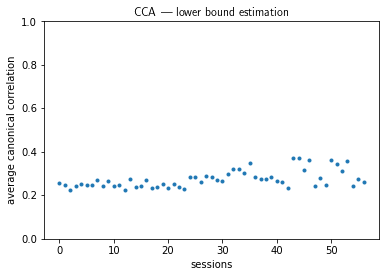

In [12]:
if "__file__" not in dir():
    plt.plot(CCs.T,'.')
    plt.ylim([0,1])
    plt.xlabel('sessions')
    plt.ylabel('average canonical correlation')
    plt.title('CCA --- lower bound estimation', usetex=True);

the average distribution of CCs

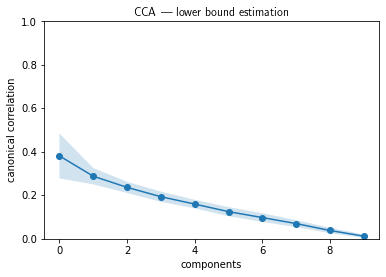

In [15]:
if "__file__" not in dir():

    CCs2=[]
    for sessionData1,sessionData2 in zip(AllData1,AllData2):
        data1 = np.reshape(sessionData1[:,:min_trials,:min_time,:], (-1,n_components))
        data2 = np.reshape(sessionData2[:,:min_trials,:min_time,:], (-1,n_components))
        CCs2.append(dt.canoncorr(data1, data2))
    CC_lower_bound = np.array(CCs2).T

    _,ax = plt.subplots()

    utility.shaded_errorbar(ax, CC_lower_bound, marker = 'o')
    ax.set_ylim([0,1])
    ax.set_xlabel('components')
    ax.set_ylabel('canonical correlation')
    ax.set_title('CCA --- lower bound estimation', usetex=True);

## within monkey, within area, across epochs

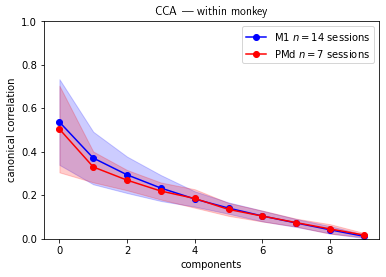

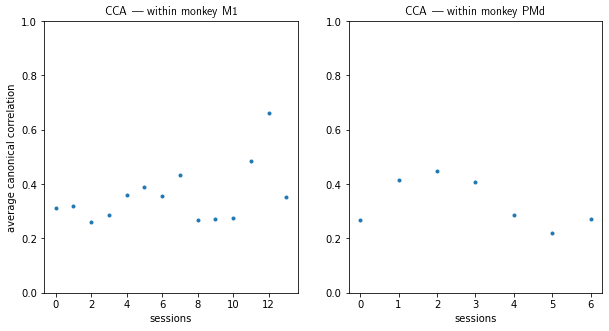

In [8]:
single_FileList1 = []
for I, _ in enumerate(full_list_M1):
    single_FileList1.append(I)

single_FileList2 = []
for I, (animal1,session1) in enumerate(full_list_PMd):
    single_FileList2.append(I)


warnings.filterwarnings("ignore")
#M1
side1df = [allDFs_M1[i] for i in single_FileList1]
AllData1 = dt.get_data_array(side1df, prep_epoch, area=areas[0], model=n_components)
AllData1_ = dt.get_data_array(side1df, fixation_epoch, area=areas[0], model=n_components)

# PMd
side2df = [allDFs_PMd[j] for j in single_FileList2]
AllData2 = dt.get_data_array(side2df, exec_epoch, area=areas[1], model=n_components)
AllData2_ = dt.get_data_array(side2df, fixation_epoch, area=areas[1], model=n_components)

warnings.filterwarnings("default")



inCCs0=[]
for sessionData1,sessionData2 in zip(AllData1,AllData1_):
    data1 = np.reshape(sessionData1, (-1,n_components))
    data2 = np.reshape(sessionData2, (-1,n_components))
    inCCs0.append(dt.canoncorr(data1, data2))
CC_lower_bound_M1 = np.array(inCCs0).T

inCCs1=[]
for sessionData1,sessionData2 in zip(AllData2,AllData2_):
    data1 = np.reshape(sessionData1, (-1,n_components))
    data2 = np.reshape(sessionData2, (-1,n_components))
    inCCs1.append(dt.canoncorr(data1, data2))
CC_lower_bound_PMd = np.array(inCCs1).T
warnings.filterwarnings("default")

if "__file__" in dir():  # runs when the notebook is being `imported` from another notebook
    print('variables: `CC_lower_bound_M1` and `CC_lower_bound_PMd` hold the lower bound correlations')
    del allDFs_M1, allDFs_PMd, side1df, side2df

# plotting
if "__file__" not in dir():
    _,ax = plt.subplots()

    utility.shaded_errorbar(ax, CC_lower_bound_M1, color='b', marker = 'o', label=f'{areas[0]} $n={CC_lower_bound_M1.shape[1]}$ sessions')
    utility.shaded_errorbar(ax, CC_lower_bound_PMd, color='r', marker = 'o', label=f'{areas[1]} $n={CC_lower_bound_PMd.shape[1]}$ sessions')
    ax.set_ylim([0,1])
    ax.set_xlabel('components')
    ax.legend()
    ax.set_ylabel('canonical correlation')
    ax.set_title('CCA --- within monkey', usetex=True);

    fig,axes = plt.subplots(ncols=2, figsize=(10,5))
    axes[0].plot(CC_lower_bound_M1[:4,:].mean(axis=0),'.')
    axes[1].plot(CC_lower_bound_PMd[:4,:].mean(axis=0),'.')
    axes[0].set_ylabel('average canonical correlation')
    for i, ax in enumerate(axes):
        ax.set_title(f'CCA --- within monkey {areas[i]} ', usetex=True);
        ax.set_ylim([0,1])
        ax.set_xlabel('sessions')

prep vs Fixation --- old style

len(pairFileList1)=14
min_trials=16
min_time=15
min_trials_=15
min_time_=15


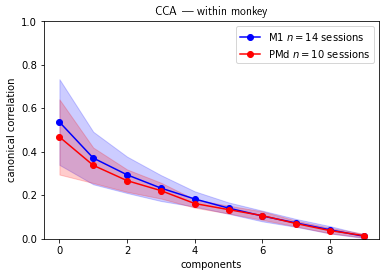

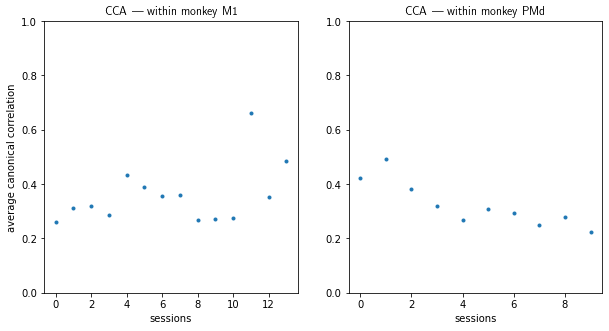

In [8]:
if "__file__" not in dir():
    pairFileList1 = []
    for animal1 in GoodDataList[areas[0]]:
        path1List = [root/animal1/GoodDataList[areas[0]][animal1][i] for i,_ in enumerate(GoodDataList[areas[0]][animal1])]
        for path1 in path1List:
            df1 = dt.load_pyal_data(path1)
            pairFileList1.append(df1)

    print(f'{len(pairFileList1)=}')


    pairFileList2 = []
    for animal1 in GoodDataList[areas[1]]:
        path1List = [root/animal1/GoodDataList[areas[1]][animal1][i] for i,_ in enumerate(GoodDataList[areas[1]][animal1])]
        for path1 in path1List:
            df1 = dt.load_pyal_data(path1)
            pairFileList2.append(df1)



    warnings.filterwarnings("ignore")
    gc.collect()
    pairFileList_area0 = [prep_general(df) for df in pairFileList1]
    del pairFileList1
    gc.collect()
    pairFileList_area1 = [prep_general(df) for  df in pairFileList2]
    del pairFileList2
    gc.collect()
    warnings.filterwarnings("default")

    warnings.filterwarnings("ignore")
    side1df = pairFileList_area0
    AllData1 = dt.get_data_array(side1df, fixation_epoch, area=areas[0], model=n_components)
    AllData2 = dt.get_data_array(side1df, prep_epoch, area=areas[0], model=n_components)
    _,_, min_trials, min_time,_ = np.min((AllData1.shape,AllData2.shape),axis=0)
    print(f'{min_trials=}\n{min_time=}')
    # PMd
    side2df = pairFileList_area1
    AllData1_ = dt.get_data_array(side2df, fixation_epoch, area=areas[1], model=n_components)
    AllData2_ = dt.get_data_array(side2df, prep_epoch, area=areas[1], model=n_components)
    _,_, min_trials_, min_time_,_ = np.min((AllData1_.shape,AllData2_.shape),axis=0)
    print(f'{min_trials_=}\n{min_time_=}')

    inCCs0=[]
    for sessionData1,sessionData2 in zip(AllData1,AllData2):
        data1 = np.reshape(sessionData1[:,:min_trials,:min_time,:], (-1,n_components))
        data2 = np.reshape(sessionData2[:,:min_trials,:min_time,:], (-1,n_components))
        inCCs0.append(dt.canoncorr(data1, data2))
    inCCs0 = np.array(inCCs0).T

    inCCs1=[]
    for sessionData1,sessionData2 in zip(AllData1_,AllData2_):
        data1 = np.reshape(sessionData1[:,:min_trials_,:min_time_,:], (-1,n_components))
        data2 = np.reshape(sessionData2[:,:min_trials_,:min_time_,:], (-1,n_components))
        inCCs1.append(dt.canoncorr(data1, data2))
    inCCs1 = np.array(inCCs1).T
    warnings.filterwarnings("default")


    # plotting
    _,ax = plt.subplots()

    utility.shaded_errorbar(ax, inCCs0, color='b', marker = 'o', label=f'{areas[0]} $n={inCCs0.shape[1]}$ sessions')
    utility.shaded_errorbar(ax, inCCs1, color='r', marker = 'o', label=f'{areas[1]} $n={inCCs1.shape[1]}$ sessions')
    ax.set_ylim([0,1])
    ax.set_xlabel('components')
    ax.legend()
    ax.set_ylabel('canonical correlation')
    ax.set_title('CCA --- within monkey', usetex=True);

    fig,axes = plt.subplots(ncols=2, figsize=(10,5))
    axes[0].plot(inCCs0[:4,:].mean(axis=0),'.')
    axes[1].plot(inCCs1[:4,:].mean(axis=0),'.')
    axes[0].set_ylabel('average canonical correlation')
    for i, ax in enumerate(axes):
        ax.set_title(f'CCA --- within monkey {areas[i]} ', usetex=True);
        ax.set_ylim([0,1])
        ax.set_xlabel('sessions')